### Superimposing the trajectory on the magnetic field 

In [255]:
using Pkg
using TOML 
using LinearAlgebra
using DifferentialEquations
using Random
using Plots
using Interpolations 

In [256]:
include(joinpath(@__DIR__, "..", "src", "utils.jl"))
include(joinpath(@__DIR__, "..", "src", "constants.jl"))
include(joinpath(@__DIR__, "..", "src", "magnetic_field.jl"))
include(joinpath(@__DIR__, "..", "src", "plasma_field.jl"))
include(joinpath(@__DIR__, "..", "src", "plotting.jl"))
include(joinpath(@__DIR__, "..", "src", "charging.jl"))
include(joinpath(@__DIR__, "..", "src", "trajectory.jl")) 

EqMotionContinuous! (generic function with 1 method)

In [257]:
using JLD2, FileIO
data = load(joinpath(@__DIR__, "..", "data", "charging_dict.jld2"))
charging_dict = data["charging_dict"]

Dict{Any, Any} with 3 entries:
  "silicate"     => Dict{Any, Any}(50=>Dict{Any, Any}("Heliosheath"=>Dict{Any, …
  "carbonaceous" => Dict{Any, Any}(50=>Dict{Any, Any}("Heliosheath"=>Dict{Any, …
  "metadata"     => Dict{String, Vector}("materials"=>["silicate", "carbonaceou…

In [234]:
input_file = joinpath(@__DIR__, "..", "main", "input_values.toml")
input_parameters = load_parameters(input_file) 

println("=== Input Parameters === \n") 
pretty_print_table(input_parameters)  
println("\n")

=== Input Parameters === 

particle_size = 50                                            n_grid = 20                                                 
distance_TS = 1.1967829656e13                                 charging_type = continuous                                  
plasma_model = turning_turning                                q_over_m_value = 16.0                                       
beta_angle = 0.0                                              B_mag_ISM = 6.0e-10                                         
mode = full                                                   distance_Approach = 2.2439680605e12                         
dt = 7000.0                                                   particle_type = silicate                                    
alpha_angle = 180.0                                           plane = both                                                
plot_color = speed                                            plot_vectors = true                               

In [ ]:
input_parameters["plasma_model"] = "straight_straight" #"turning_turning" 
input_parameters["particle_type"] = "silicate"

input_parameters["r0"] = [ 105.0, 0.0, 15.0 ] .* AU  
input_parameters["B_field_time_offset"] = 5.0 * yr #(7.0 + 2.0) * yr 

input_parameters["particle_size"] = 250 #50
input_parameters["particle_type"] = "silicate"

input_parameters["charging_type"] = "instant" #"instant" #"constant" #"continuous"

v_calculated = voltage_at_size(charging_dict, input_parameters["particle_type"], "TerminationShock", input_parameters["particle_size"])
rho = input_parameters["particle_type"] == "carbonaceous" ? 2.5 : 3.3 
input_parameters["q_over_m_value"] = calculate_qm(v_calculated, input_parameters["particle_size"], rho) # Only relevant for constant charge. 

input_parameters["dt"] = 50_000
input_parameters["max_time"] = 18.0 * yr 

6.942672e8

In [237]:
res_traj, saved_charges = ComputeTrajectory(input_parameters); 

Affect triggered at 100.0 AU. New Q/m of 1.512
Affect triggered at 80.0 AU. New Q/m of 1.866
--- Solution Characteristics ---
Integration time: 0.0 → 22.0 years
Solution size: (6, 13890)


In [238]:
sol_time = res_traj.t #./ yr
sol_x = [u[1] for u in res_traj.u] #./ AU
sol_y = [u[2] for u in res_traj.u] #./ AU
sol_z = [u[3] for u in res_traj.u] #./ AU
trajectory_duration =  (sol_time[end] - sol_time[1])   
sol_speed = [norm(u[4:6]) for u in res_traj.u] #./ 1e3   # in km/s   
npts = length(sol_time)
if npts > 1000
    idx = round.(Int, range(1, npts, length=1000))
    sol_time = sol_time[idx]
    sol_x, sol_y, sol_z, sol_speed = sol_x[idx], sol_y[idx], sol_z[idx], sol_speed[idx]
end    

([1.57077764235e13, 1.56895764235e13, 1.56713764235e13, 1.56531764235e13, 1.56349764235e13, 1.56167764235e13, 1.55998764235e13, 1.55816764235e13, 1.55634764235e13, 1.55452764235e13  …  -3.268185887885133e12, -3.2928730533710366e12, -3.3175311694716606e12, -3.342166835549989e12, -3.3650268260658496e12, -3.3896173589599243e12, -3.4141789733597876e12, -3.438727946945439e12, -3.4632638308070537e12, -3.486449535223347e12], [0.0, 2.228857174448183e-6, 4.457714348896366e-6, 6.686571523344546e-6, 8.915428697792733e-6, 1.1144285872240924e-5, 1.3213938962799959e-5, 1.5442796137248146e-5, 1.7671653311696314e-5, 1.990051048614448e-5  …  6.392631679736329e9, 6.420566964144974e9, 6.448463442417455e9, 6.476329894100098e9, 6.502184477544612e9, 6.5299904484128275e9, 6.557757600974034e9, 6.585507771536649e9, 6.613240337638876e9, 6.63944109536526e9], [2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.2439680605e12, 2.

In [240]:
# --- Helper functions --- 
flat_polarity(B_vector) = sign(B_vector[2])

spherical_polarity(u, B_vector) = begin
    phi = atan(u[2], u[1])
    e_phi = [-sin(phi), cos(phi), 0.0]
    sign(dot(B_vector, e_phi))
end

# --- Calculate magnetic field polarity over regimes of interest --- 
function B_data(input; radius=90.0, timestamp=0.0, n_x=20, n_t=20, n_z=20, visual_mode="tz", xspan_range=(70,110), yspan_range=20)

    @assert haskey(input, "min_time") && haskey(input, "max_time")

    x_span_low, x_span_high = xspan_range #(0.1, 110)
    y_span_value = yspan_range #55

    if visual_mode == "tz"
        xspan = range(timestamp + input["min_time"], timestamp + input["max_time"], n_t) #time axis
        yspan = range(-y_span_value, y_span_value, n_z) #z axis
    elseif visual_mode == "xz"
        xspan = range(x_span_low, x_span_high, n_x) #x axis 
        yspan = range(-y_span_value, y_span_value, n_z) #z axis 
    else 
        error("visual_mode not recognised")
    end 

    B_pol = zeros(length(xspan), length(yspan))

    if visual_mode == "tz"
        for (i, x) in enumerate(xspan)
            for (j, y) in enumerate(yspan) 
                u = [radius*AU, 0.0, y*AU, 0.0, 0.0, 0.0]
                B_vector = B_field(u, input; t=x) 
                if input["dist_measure"] == "flat"
                    pol = flat_polarity(B_vector)
                    B_pol[i,j] = pol 
                else 
                    pol = spherical_polarity(u, B_vector)
                    B_pol[i,j] = pol  
                end 
            end
        end
    elseif visual_mode == "xz"
        for (i, x) in enumerate(xspan)
            for (j, y) in enumerate(yspan) 
                u = [x*AU, 0.0, y*AU, 0.0, 0.0, 0.0]
                B_vector = B_field(u, input; t=timestamp)
                if input["dist_measure"] == "flat"
                    pol = flat_polarity(B_vector)
                    B_pol[i,j] = pol 
                else 
                    pol = spherical_polarity(u, B_vector)
                    B_pol[i,j] = pol  
                end 
            end
        end
    end 
    return xspan, yspan, B_pol 
end


B_data (generic function with 1 method)

In [242]:
gr()

n_dense = 500
vis_mode = "xz"
xspr = (0.1,105) 
yspr = xspr[2] - xspr[1]
time_value = 3.0 * yr 

9.46728e7

In [243]:
x, y, Bvals = B_data(
    input_parameters; radius = rad_val, timestamp = time_value,
    n_x = n_dense, n_t = n_dense, n_z = n_dense,
    visual_mode = vis_mode, xspan_range = xspr, yspan_range = yspr )

if vis_mode == "xz"
    divisor = 1.0
    title_string = "Time: $(round(time_value / yr, digits=2)) yr"
    xlabel, ylabel = ("x [AU]", "z [AU]")
else
    divisor = yr
    title_string = "Radius: $(rad_val) AU"
    xlabel, ylabel = ("t [yr]", "z [AU]")
end

("x [AU]", "z [AU]")

In [244]:
idx_time = argmin(abs.(sol_time .- time_value))

137

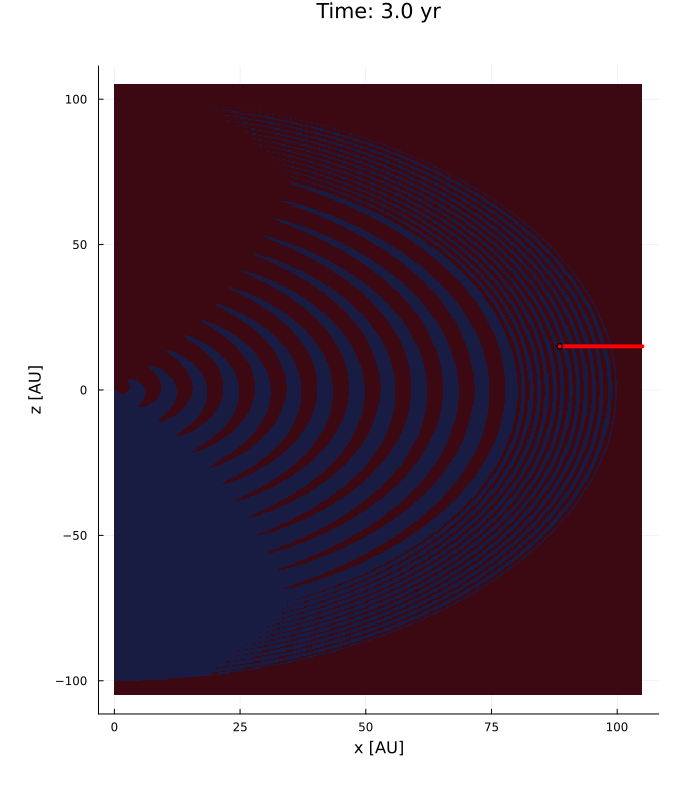

In [245]:
plt = heatmap(
    x ./ divisor, y, Bvals', 
    margin = 8Plots.mm, size = (700, 800), title = title_string,
    xlabel = xlabel, ylabel = ylabel, colorbar = false, c=:balance )

plot!(plt, sol_x[1:idx_time] ./ AU, sol_z[1:idx_time] ./ AU,
      lw = 4, color = :red, label = "")

scatter!(plt,
    [sol_x[idx_time]] ./ AU,
    [sol_z[idx_time]] ./ AU,
    color = :red,
    markersize = 3,
    label = "")


In [248]:
outdir = joinpath(@__DIR__, "..", "data")
mkpath(outdir)   # ensure folder exists
outfile = joinpath(outdir, "Bfield_with_Traj.gif") 

"c:\\Users\\brian\\Documents\\CosmicDust\\Code\\HeliopauseBoundaryCode\\tests\\..\\data\\Bfield_with_Traj.gif"

In [249]:
t_start = input_parameters["min_time"] #0.0 * yr 
t_end = input_parameters["max_time"] # 1.0 * yr 
B_time_offset = input_parameters["B_field_time_offset"]

times_number = Int( floor(27.0 / 5.0) * floor(365.0 / 27.0) * (t_end - t_start) / yr ) 
println("Number of timesteps: $times_number")

times = range(t_start, t_end; length=50) #times_number)  

Number of timesteps: 1430


0.0:1.4168718367346939e7:6.942672e8

In [250]:
gr()

n_dense = 500
vis_mode = "xz"
xspr = (0.1,105) 
yspr = xspr[2] - xspr[1]

anim = @animate for (i, t) in enumerate(times)

    @info "Rendering frame $i / $(length(times))  |  t = $(round(t/yr, digits=3)) yr"

    x, y, Bvals = B_data(
        input_parameters;
        radius = rad_val,
        timestamp   = t,
        n_x    = n_dense,
        n_t    = n_dense,
        n_z    = n_dense,
        visual_mode = vis_mode, 
        xspan_range = xspr, 
        yspan_range = yspr
    )

    if vis_mode == "xz"
        divisor = 1.0 

        title_string = "Time: $(round(t / yr, digits=2)) yr - " *
                        "$(input_parameters["particle_type"]) of $(input_parameters["particle_size"]) nm " * 
                        "with $(input_parameters["charging_type"]) charging"
        xlabel, ylabel = ("x [AU]", "z [AU]")
    else
        divisor = yr
        title_string = "Radius: $(rad_val) AU"
        xlabel, ylabel = ("t [yr]", "z [AU]")
    end

    plt = heatmap(
        x ./ divisor, y, Bvals', 
        margin = 8Plots.mm, size = (700, 800), title = title_string,
        xlabel = xlabel, ylabel = ylabel, colorbar = false, c=:balance )

    idx_time = argmin(abs.(sol_time .- t))

    plot!(plt, sol_x[1:idx_time] ./ AU, sol_z[1:idx_time] ./ AU,
        lw = 4, color = :red, label = "")

    scatter!(plt,
        [sol_x[idx_time]] ./ AU,
        [sol_z[idx_time]] ./ AU,
        color = :red,
        markersize = 3,
        label = "")

end


┌ Info: Rendering frame 1 / 50  |  t = 0.0 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X60sZmlsZQ==.jl:10
┌ Info: Rendering frame 2 / 50  |  t = 0.449 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X60sZmlsZQ==.jl:10
┌ Info: Rendering frame 3 / 50  |  t = 0.898 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X60sZmlsZQ==.jl:10
┌ Info: Rendering frame 4 / 50  |  t = 1.347 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X60sZmlsZQ==.jl:10
┌ Info: Rendering frame 5 / 50  |  t = 1.796 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X60sZmlsZQ==.jl:10
┌ Info: Rendering fram

Animation("C:\\Users\\brian\\AppData\\Local\\Temp\\jl_zoVYCY", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\data\Bfield_with_Traj.gif
└ @ Plots C:\Users\brian\.julia\packages\Plots\ywg93\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\brian\\Documents\\CosmicDust\\Code\\HeliopauseBoundaryCode\\data\\Bfield_with_Traj.gif")
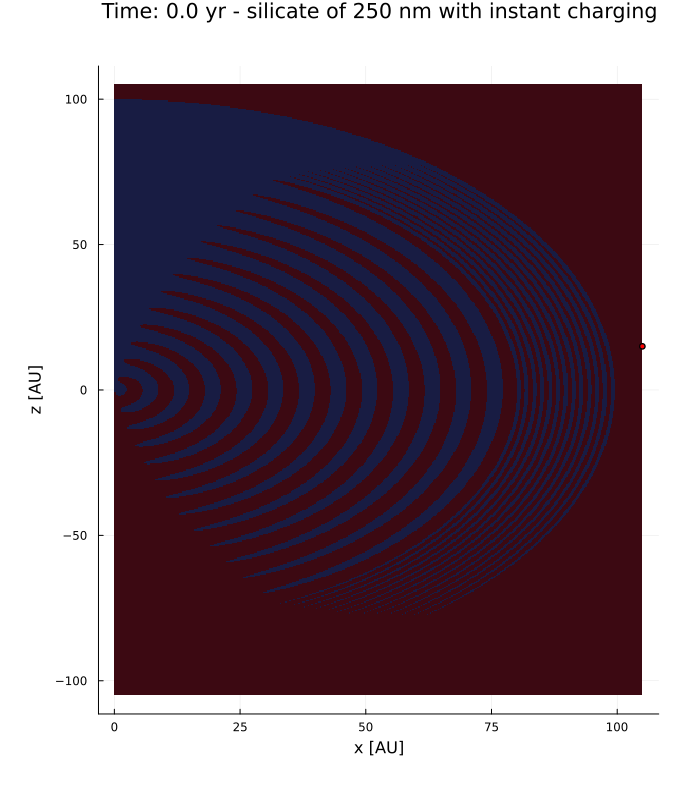

In [251]:
gif(anim, outfile; fps=2)